# Asphalt mix prediction after plastic addition

In [65]:
#%% IMPORTS
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from scipy.stats import normaltest
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from IPython.display import display, Markdown, Latex
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge



## Methods

In [ ]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [115]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

##  Data Import 

In [121]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption [%]',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [113]:
dfAirVoids = returnDf('AirVoids')
dfMS = returnDf('MS')
dfMF = returnDf('MF')
dfITS = returnDf('ITS')
dfTSR = returnDf('TSR')

-------------------------------
#  1. Air Voids

In [41]:
dfAirVoids = eliminateOutliers(dfAirVoids, 'Air voids of the sample (%)')

Initial dataframe size: (305, 35)
Final dataframe size: (288, 35)


## 1.1 Data Exploration
###  1.1.1 Total Sample

In [42]:
dfAirVoids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1 to 305
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              288 non-null    object 
 1   Global ID                               288 non-null    object 
 2   Modified asphaly Mix?                   288 non-null    object 
 3   Agreggate Type                          197 non-null    object 
 4   Aggregate absorption [%]                231 non-null    float64
 5   Apparent specific gravity               77 non-null     float64
 6   0.075                                   254 non-null    float64
 7   0.3                                     254 non-null    float64
 8   0.6                                     251 non-null    float64
 9   2.36                                    258 non-null    float64
 10  4.75                                    258 non-null    float6

In [129]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['Air voids of the sample (%)']

In [93]:
dfAirVoids.describe(include = 'all')

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         305       305                   305            205   
unique         28       305                     2              7   
top            19       276                   Yes        Granite   
freq           70         1                   241             99   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption [%]  Apparent specific gravity       0.075  \
count                 237.000000                  79.000000  269.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.113819                   2.706203    5.367472   
std                     0.901977                   0.066591    1.437309   
min                     0.130000                   2.590000    2.190000   
25%                     0.470000                   2.650000    4.620000   
50%                     0.990000                   2.710000    5.280000   
75%                     1.200000                   2.740000    5.980000   
max                     3.040000                   2.800000   10.300000   

              0.3         0.6        2.36        4.75         9.5        12.5  \
count   269.00000  266.000000  273.000000  273.000000  266.000000  258.000000   
unique        NaN         NaN         NaN         NaN         NaN         NaN   
top           NaN         NaN         NaN         NaN         NaN         NaN   
freq          NaN         NaN         NaN         NaN         NaN         NaN   
mean     13.03803   20.222218   36.018864   48.102527   66.324812   78.130116   
std       3.44642    6.382403    7.256635    9.094616   10.704868   11.154531   
min       5.30000   10.070000   20.000000   24.000000   47.000000   66.630000   
25%      10.15000   14.770000   29.850000   41.540000   59.850000   69.380000   
50%      12.97000   19.780000   35.370000   46.150000   60.510000   78.000000   
75%      14.47000   21.250000   38.800000   50.910000   70.610000   87.740000   
max      24.50000   39.160000   54.100000   71.080000   96.870000  100.000000   

                19 Filler used Bitumen Type Penetration Grade  \
count   273.000000         132                            305   
unique         NaN           4                              6   
top            NaN  Stone dust                          50/70   
freq           NaN          53                            119   
mean     91.661172         NaN                            NaN   
std       7.346771         NaN                            NaN   
min      83.110000         NaN                            NaN   
25%      84.460000         NaN                            NaN   
50%      94.520000         NaN                            NaN   
75%     100.000000         NaN                            NaN   
max     100.020000         NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     305              281   
unique                                      3                8   
top                                     50/70               PE   
freq                                      214              135   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%    

In total, there is $\color{red}{\text{288}}$ observations. Let's see if there is any correlation with the continual and categorical variables. The mean of $\color{red}{\text{Air voids}}$, which is the common value for the optimum asphalt mix design.

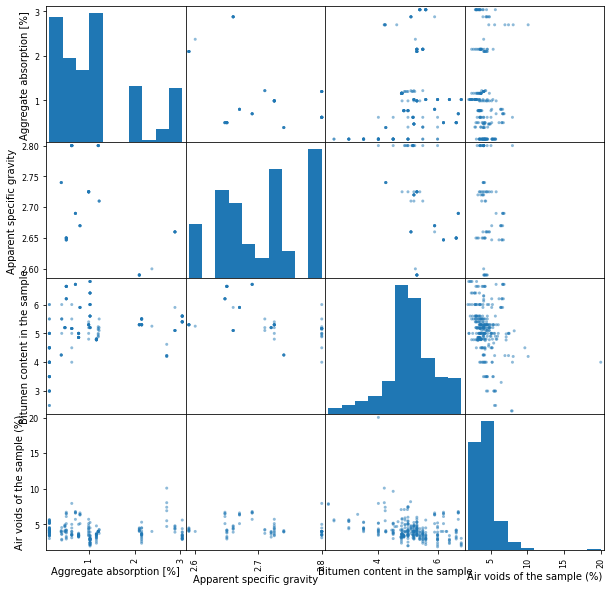

In [94]:
scatter_matrix(dfAirVoids[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'Air voids of the sample (%)']], figsize=(10, 10))
plt.show()

It is possible to see a negative correlation between $\color{red}{\text{Bitumen Content}}$  and $\color{red}{\text{Air Voids}}$. This makes sense because higher bitumen quantities will fill more voids in the mixture.

Among the categorical variables, we will initially focus on the general ones that might have an effect on air voids: $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Filler used}}$ and $\color{red}{\text{Bitumen Grade}}$

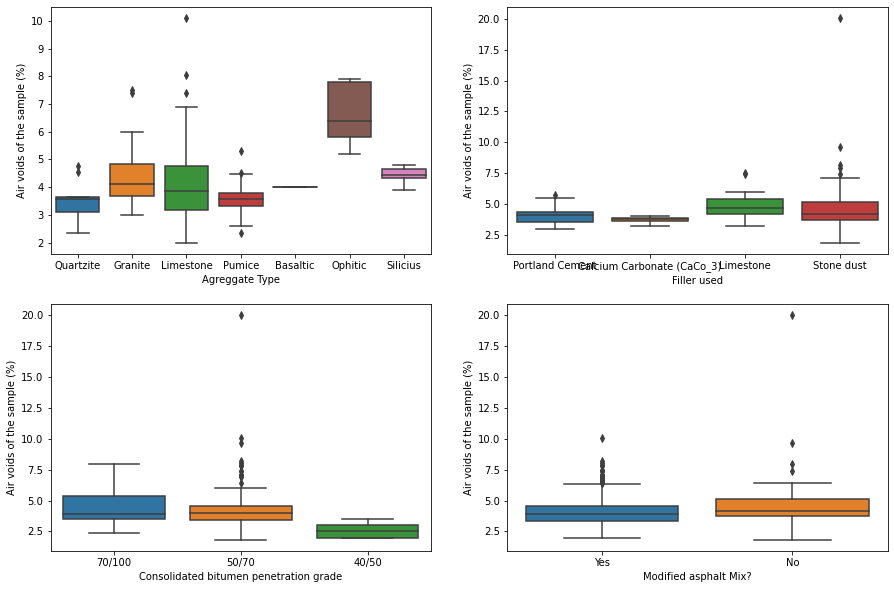

In [114]:
displayBoxPlotGraphs(dataFrame = dfAirVoids, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

Within the  $\color{red}{\text{Aggregate type}}$, although it exists differences -especially with the Ophitic- this data migh not be robust enough due to the sample size of this type of aggregate. It happens the same with the  $\color{red}{\text{Bitumen type}}$, where only  $\color{purple}{\text{5}}$ observations used the 40/50 bitumen. The  $\color{red}{\text{addition of plastic}}$ seems to have not strong influence in the air voids.

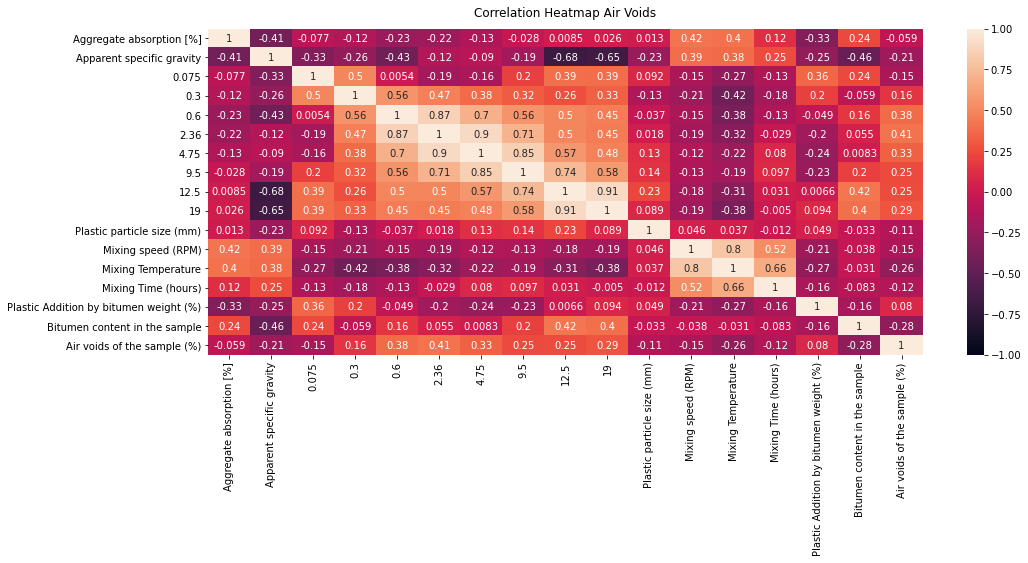

In [98]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoids.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Air Voids', fontdict={'fontsize':12}, pad=12);

###  1.1.2 Modified mixtures

In [99]:
dfAirVoidsModified = dfAirVoids[dfAirVoids['Modified asphalt Mix?']=='Yes']
dfAirVoidsModified.describe(include = "all")

Article ID Global ID Modified asphalt Mix? Agreggate Type  \
count         241       241                   241            170   
unique         27       241                     1              7   
top            19       276                   Yes        Granite   
freq           62         1                   241             83   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption [%]  Apparent specific gravity       0.075  \
count                 189.000000                  57.000000  212.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.138571                   2.699789    5.438679   
std                     0.918272                   0.065966    1.390635   
min                     0.130000                   2.590000    2.190000   
25%                     0.470000                   2.650000    4.620000   
50%                     1.020000                   2.690000    5.280000   
75%                     1.220000                   2.740000    5.980000   
max                     3.040000                   2.800000   10.300000   

               0.3         0.6        2.36        4.75         9.5  \
count   212.000000  209.000000  215.000000  215.000000  209.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     13.106462   20.116124   35.667023   47.892884   66.195311   
std       3.442233    6.424508    7.283215    9.282133   10.741268   
min       5.300000   10.070000   20.000000   24.000000   47.000000   
25%      10.150000   14.770000   29.850000   41.540000   59.850000   
50%      12.970000   19.780000   35.370000   46.150000   60.510000   
75%      14.470000   21.250000   38.800000   51.350000   70.480000   
max      24.500000   39.160000   54.100000   71.080000   96.870000   

              12.5          19      Filler used  \
count   206.000000  215.000000               99   
unique         NaN         NaN                4   
top            NaN         NaN  Portland Cement   
freq           NaN         NaN               38   
mean     77.962427   91.331116              NaN   
std      11.437004    7.526107              NaN   
min      66.630000   83.110000              NaN   
25%      69.380000   84.460000              NaN   
50%      69.380000   90.610000              NaN   
75%      87.740000  100.000000              NaN   
max     100.000000  100.020000              NaN   

       Bitumen Type Penetration Grade Consolidated bitumen penetration grade  \
count                             241                                    241   
unique                              6                                      3   
top                             50/70                                  50/70   
freq                               96                                    167   
mean                              NaN                                    NaN   
std                               NaN                                    NaN   
min                               NaN                                    NaN   
25%                               NaN                                    NaN   
50%                               NaN                                    NaN   
75%                               N

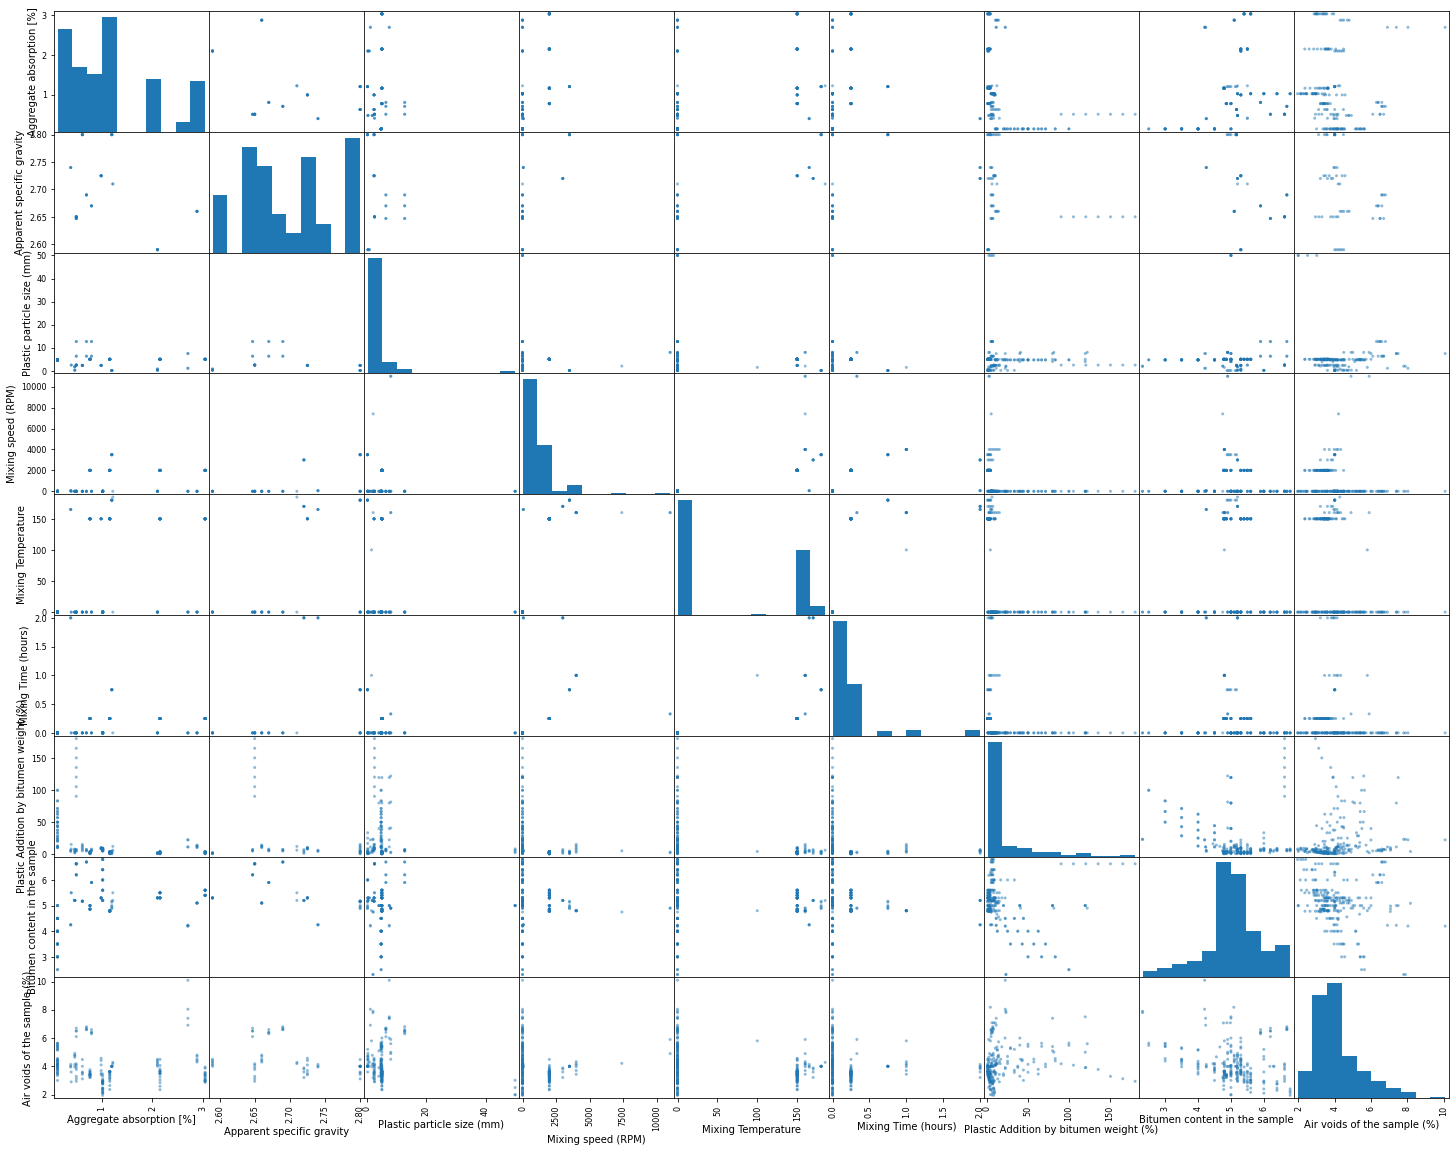

In [128]:
scatter_matrix(dfAirVoidsModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoidsModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

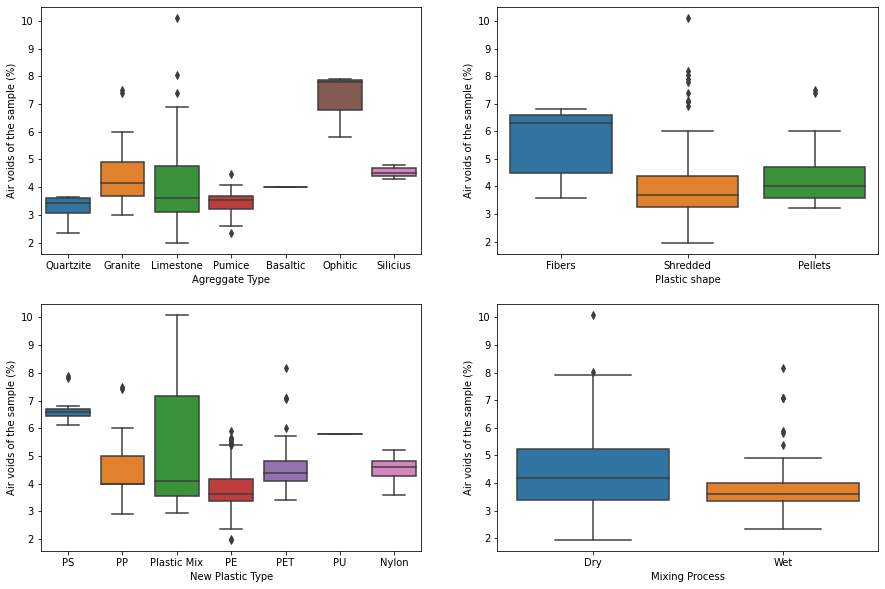

In [135]:
displayBoxPlotGraphs(dataFrame = dfAirVoidsModified, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Not much difference among dry and wet

###  1.1.3 Wet vs. Dry Mixing

In [ ]:
dfAirVoidsWetvsDry = dfAirVoidsModified [['Mixing Process', 'Air voids of the sample (%)']]
dfAirVoidsWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfAirVoidsModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Some important points:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Total sample: # observations = 288, Mean = 4, Standard deviation = 0.98 
*   Sample with asphalt modified: # observations = 228, Mean = 3.94, Standard deviation = 1.017
*   It seems that there will be a strong correlation with $\color{red}{\text{Aggregates gradation}}$.
*   Dry vs. Wet:
    *   Not strong difference between dry and wet.
    *   Mean in wet = 3.64, Mean in dry = 4.16.


## 1.2 Data Pre-processing

### 1.2.1 Categorical variables and Missing Values

In [100]:
dfAirVoids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 1 to 305
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              305 non-null    object 
 1   Global ID                               305 non-null    object 
 2   Modified asphalt Mix?                   305 non-null    object 
 3   Agreggate Type                          205 non-null    object 
 4   Aggregate absorption [%]                237 non-null    float64
 5   Apparent specific gravity               79 non-null     float64
 6   0.075                                   269 non-null    float64
 7   0.3                                     269 non-null    float64
 8   0.6                                     266 non-null    float64
 9   2.36                                    273 non-null    float64
 10  4.75                                    273 non-null    float6

*   Process for dealing with missing categorical values:

    1.  I will eliminate the rows with Nan values in the column $\color{red}{\text{New Plastic Type}}$. In total, there is 24 missing values, which represent 8.33% of the sample
    2.  Replace the 'N/a' value when there is no modifiation of the asphalt mix.

*   Process for dealing with missing numeric values:

    *   The imputer used was the multivariable imputer, and the estimator was the ExtraTreeRegressor ([link][1]).
    By using this estimator, I did not get any negative values among the missing features, and it presents a low MSE value.
    
[1]:https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py  

In [101]:
#CATEGORICAL VARIABLES
dfAirVoidsCleaned = dfAirVoids.drop(['Article ID', 'Global ID','Agreggate Type', 'Apparent specific gravity', 'Filler used', 'Bitumen Type Penetration Grade', 'Property', 'Units', 'Plastic Size' ], axis = 1)
dfAirVoidsCleaned = dfAirVoidsCleaned.replace('N/a', 0)
dfAirVoidsCleaned = dfAirVoidsCleaned.dropna(subset=['New Plastic Type'])
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, drop_first=True)
dfAirVoidsCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 1 to 305
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption [%]                       213 non-null    float64
 1   0.075                                          269 non-null    float64
 2   0.3                                            269 non-null    float64
 3   0.6                                            266 non-null    float64
 4   2.36                                           273 non-null    float64
 5   4.75                                           273 non-null    float64
 6   9.5                                            266 non-null    float64
 7   12.5                                           258 non-null    float64
 8   19                                             273 non-null    float64
 9   Plastic particle size (mm)                     251 non

In [47]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=50)
n = imputer.fit_transform(dfAirVoidsCleaned)
dfCleanedImputed = pd.DataFrame(n, columns = list(dfAirVoidsCleaned.columns))
dfCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption [%]                       264 non-null    float64
 1   0.075                                          264 non-null    float64
 2   0.3                                            264 non-null    float64
 3   0.6                                            264 non-null    float64
 4   2.36                                           264 non-null    float64
 5   4.75                                           264 non-null    float64
 6   9.5                                            264 non-null    float64
 7   12.5                                           264 non-null    float64
 8   19                                             264 non-null    float64
 9   Plastic particle size (mm)                     264 non

In [ ]:
dfCleanedImputed.to_clipboard(excel = True)

### 1.2.2 Features Scaling

In [48]:
 scaler = MinMaxScaler()
 dfCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfCleanedImputed), columns = list(dfCleanedImputed.columns))

In [ ]:
dfCleanedImputedScaled.to_clipboard(excel = True)

## 1.3 Model Training

In [49]:
X = dfCleanedImputedScaled.loc[:, dfCleanedImputedScaled.columns != 'Air voids of the sample (%)']
y = dfCleanedImputedScaled.iloc[:,15]

In [50]:
#Method for displaying the MSE and best parameters
def displayScore (grid):
    display(Markdown('Lowest MSE:'+ str(-grid.best_score_)))
    display(Markdown('Best parameters: ' +str(grid.best_params_)))

### Linear Model

In [51]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X, y)
displayScore(grid)

Lowest MSE:0.038404879343425416

Best parameters: {'fit_intercept': False, 'positive': True}

### Ridge linear regression model

In [ ]:
param_grid = {'alpha': [80,81,82,83,84],
'fit_intercept': [True, False],
'solver': ['svd', 'cholesky','lsqr', 'sparse_cg']}
grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X, y)
displayScore(grid)

### Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))


In [ ]:
param_grid = {'polynomialfeatures__degree': [3,4],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X, y)
displayScore(grid)

### Ridge polynomial regression

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

In [ ]:
param_grid = {'polynomialfeatures__degree': [2, 3],
'ridge__alpha':[0.001,0.1,1,10],
'ridge__fit_intercept': [True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X, y)
displayScore(grid)

-------------------------------
#  2. Marshall Stability

In [ ]:
dfMS = eliminateOutliers(dfMS, 'MS of the sample (kN)')

## 2.1 Data Exploration
###  2.1.1 Total Sample

In [38]:
dfMS.describe(include = "all")
dfMS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 1 to 406
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ArticIe ID                              402 non-null    object 
 1   Global ID                               402 non-null    object 
 2   Modified asphaly Mix?                   402 non-null    object 
 3   Agreggate Type                          262 non-null    object 
 4   Aggregate absorption [%]                243 non-null    float64
 5   Apparent specific gravity               84 non-null     float64
 6   0.075                                   325 non-null    float64
 7   0.3                                     372 non-null    float64
 8   0.6                                     344 non-null    float64
 9   2.36                                    355 non-null    float64
 10  4.75                                    372 non-null    float6

In [64]:
dfMS.iloc[:,2:].describe(include = 'all')

Modified asphaly Mix? Agreggate Type  Aggregate absorption [%]  \
count                    402            262                243.000000   
unique                     2              7                       NaN   
top                      Yes        Granite                       NaN   
freq                     319            111                       NaN   
mean                     NaN            NaN                  1.244012   
std                      NaN            NaN                  0.946435   
min                      NaN            NaN                  0.130000   
25%                      NaN            NaN                  0.470000   
50%                      NaN            NaN                  1.020000   
75%                      NaN            NaN                  2.150000   
max                      NaN            NaN                  3.040000   

        Apparent specific gravity       0.075         0.3         0.6  \
count                   84.000000  325.000000  372.000000  344.000000   
unique                        NaN         NaN         NaN         NaN   
top                           NaN         NaN         NaN         NaN   
freq                          NaN         NaN         NaN         NaN   
mean                     2.686607    6.468615   15.077554   20.382326   
std                      0.078388    5.324622    5.751117    6.522281   
min                      2.590000    2.190000    5.300000    9.000000   
25%                      2.600000    4.620000   10.645000   14.770000   
50%                      2.685000    5.280000   13.780000   20.560000   
75%                      2.725000    6.240000   17.670000   22.820000   
max                      2.800000   33.270000   35.940000   38.600000   

              2.36        4.75         9.5        12.5          19  \
count   355.000000  372.000000  344.000000  357.000000  372.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     37.037634   48.832419   68.052878   80.658375   92.682527   
std       7.594248    8.788165   10.812028   11.598671    7.204713   
min      19.770000   23.950000   47.000000   66.630000   83.110000   
25%      33.470000   41.540000   59.850000   69.380000   84.460000   
50%      35.860000   49.350000   67.840000   79.860000   94.940000   
75%      39.000000   54.770000   75.970000   90.000000  100.000000   
max      57.460000   71.500000   95.200000  100.000000  100.020000   

       Filler used Bitumen Type Penetration Grade  \
count          161                            402   
unique           5                              5   
top     Stone dust                          60/70   
freq            81                            141   
mean           NaN                            NaN   
std            NaN                            NaN   
min            NaN                            NaN   
25%            NaN                            NaN   
50%            NaN                            NaN   
75%            NaN                            NaN   
max            NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     402              377   
unique                                      3               10   
top                                     50/70               PE   
freq                                      275              151   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%                                       NaN              NaN   
50%                                       NaN              NaN   
75%                                       NaN              NaN   
max                                       NaN    

I might have a problem with the $\color{red}{\text{Aggregate absorption}}$ because more than 20% of the data is missing. Regarding the $\color{red}{\text{MS}}$, there is a high dispersion ($\sigma$ = 4.56), and the Mean seems normal. According to the Australian standards, the minimum value of the Marshall stability is between two and eigth.

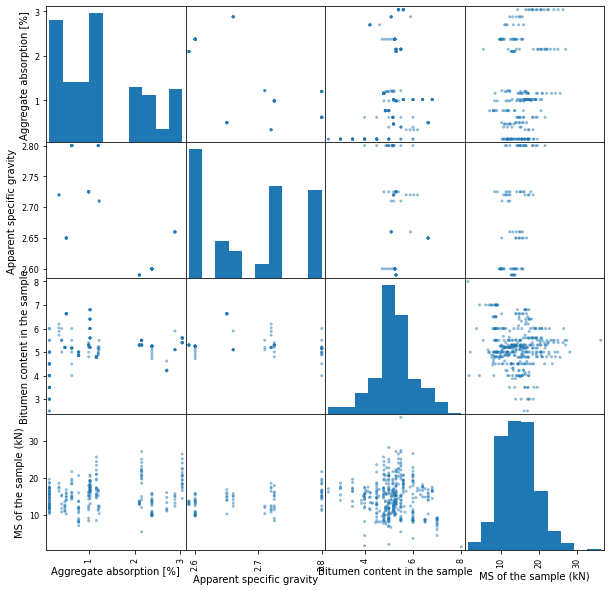

In [102]:
scatter_matrix(dfMS[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'MS of the sample (kN)']], figsize=(10, 10))
plt.show()

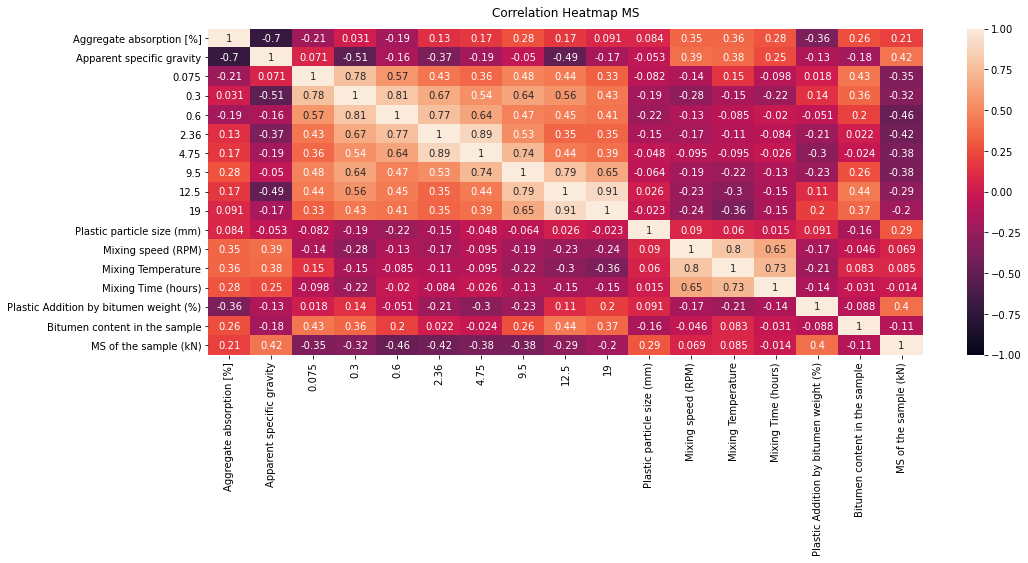

In [83]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12);

Interestingly, there is positive correlation in $\color{red}{\text{MS-Apparent specific gravity}}$ and $\color{red}{\text{MS-plastic addition by bitumen content}}$.


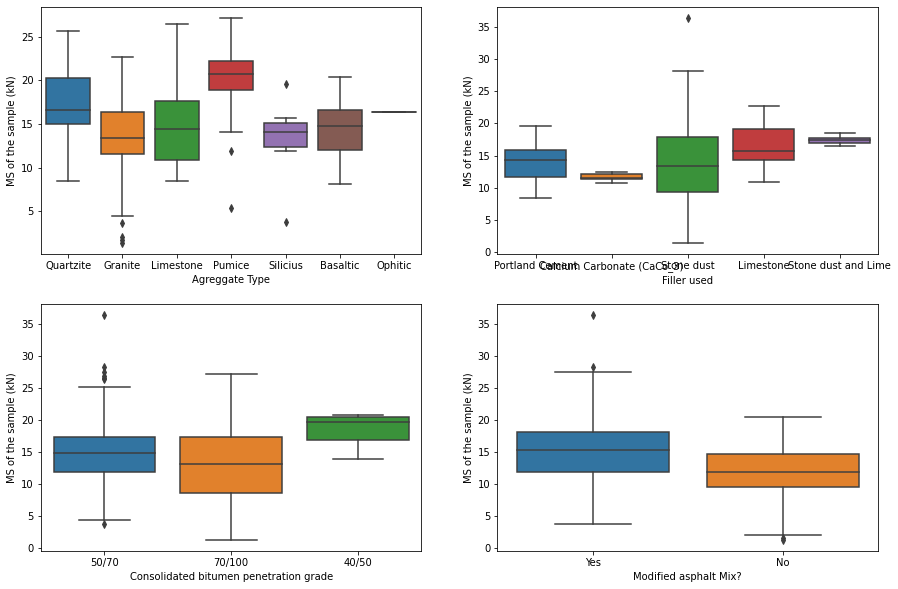

In [117]:
displayBoxPlotGraphs(dataFrame = dfMS, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

*   As it happened with the Air Voids, it exists a MS difference among the samples that employed the bitumen 40/50; however, it is important to note that the sample size for this group was not representative enough.

*   Samples with plastic modification tend to have higher MS. The glue effect of the plastic and the stiffness increase of the bitumen might serve as valid explanations.

*   No signigicant difference among the aggregate types and fillers

###  1.1.2 Modified mixtures

In [119]:
dfMSModified = dfMS[dfMS['Modified asphalt Mix?'] == 'Yes']
dfMSModified.describe(include = "all")

ArticIe ID Global ID Modified asphalt Mix? Agreggate Type  \
count         323       323                   323            216   
unique         33       323                     1              7   
top            19       102                   Yes        Granite   
freq           62         1                   323             91   
mean          NaN       NaN                   NaN            NaN   
std           NaN       NaN                   NaN            NaN   
min           NaN       NaN                   NaN            NaN   
25%           NaN       NaN                   NaN            NaN   
50%           NaN       NaN                   NaN            NaN   
75%           NaN       NaN                   NaN            NaN   
max           NaN       NaN                   NaN            NaN   

        Aggregate absorption [%]  Apparent specific gravity       0.075  \
count                 199.000000                  66.000000  257.000000   
unique                       NaN                        NaN         NaN   
top                          NaN                        NaN         NaN   
freq                         NaN                        NaN         NaN   
mean                    1.285930                   2.674545    6.185992   
std                     0.960862                   0.076710    4.527838   
min                     0.130000                   2.590000    2.190000   
25%                     0.485000                   2.600000    4.620000   
50%                     1.020000                   2.655000    5.280000   
75%                     2.150000                   2.725000    6.070000   
max                     3.040000                   2.800000   33.270000   

               0.3         0.6        2.36        4.75         9.5  \
count   298.000000  273.000000  282.000000  298.000000  273.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     15.001946   19.985934   36.666773   48.456007   68.067985   
std       5.419204    6.325022    7.523720    8.859909   10.707984   
min       5.300000    9.000000   19.770000   23.950000   47.000000   
25%      10.150000   14.770000   29.850000   41.540000   59.850000   
50%      14.470000   19.780000   35.560000   47.510000   67.840000   
75%      17.670000   21.800000   39.000000   54.770000   73.000000   
max      35.940000   38.600000   57.460000   71.500000   95.200000   

              12.5          19 Filler used Bitumen Type Penetration Grade  \
count   289.000000  298.000000         123                            323   
unique         NaN         NaN           5                              5   
top            NaN         NaN  Stone dust                          60/70   
freq           NaN         NaN          58                            115   
mean     80.684671   92.579161         NaN                            NaN   
std      11.647730    7.302103         NaN                            NaN   
min      66.630000   83.110000         NaN                            NaN   
25%      69.380000   84.460000         NaN                            NaN   
50%      79.860000   94.940000         NaN                            NaN   
75%      90.000000  100.000000         NaN                            NaN   
max     100.000000  100.020000         NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     323              298   
unique                                      3                8   
top                                     50/70               PE   
freq                                      221              151   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              Na

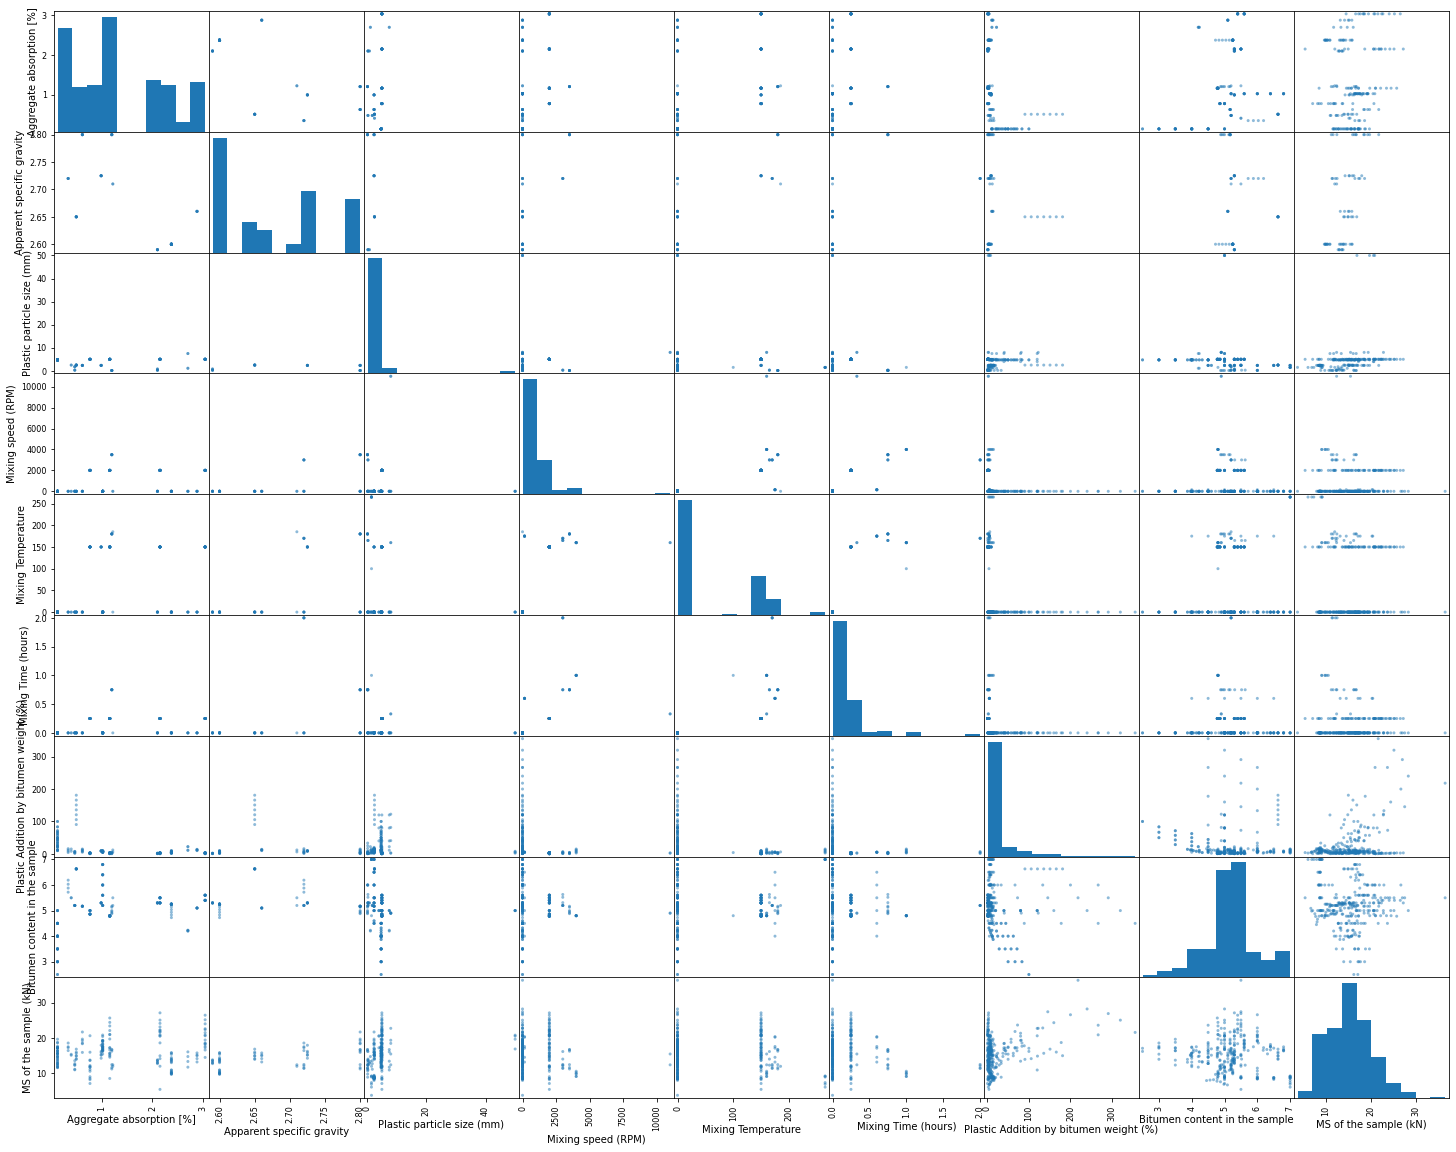

In [131]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MS of the sample (kN)']
scatter_matrix(dfMSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

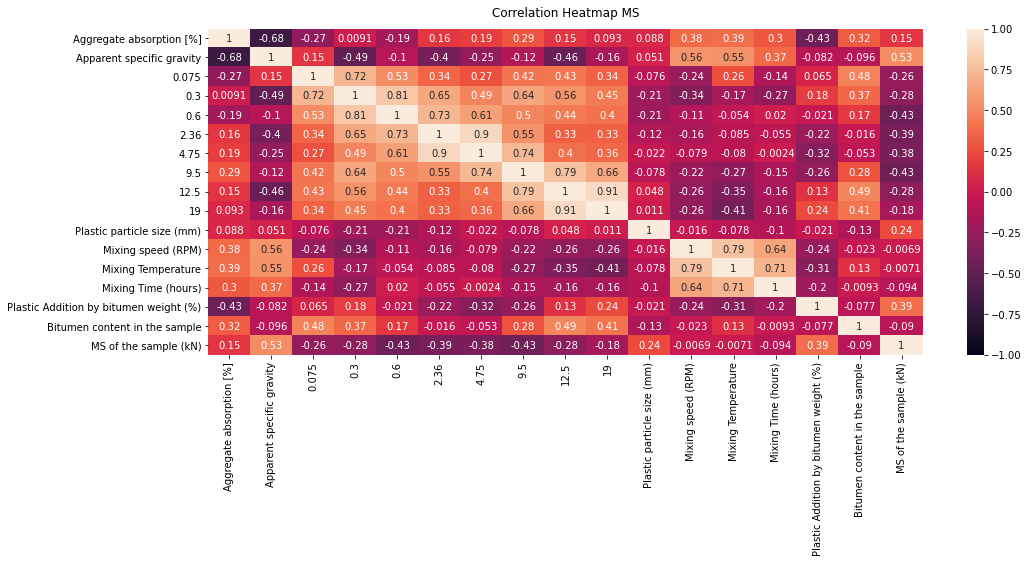

In [133]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12);

 $\color{red}{\text{MS-Apparent specific gravity}}$ presents the highest correlation with  $\color{red}{\text{MS}}$MS; however, it only has 66 observations, so it is not a convincing result. Other parameters such as  $\color{red}{\text{Plastic content}}$, and  $\color{red}{\text{gradation}}$ present an slight effect on the MS.

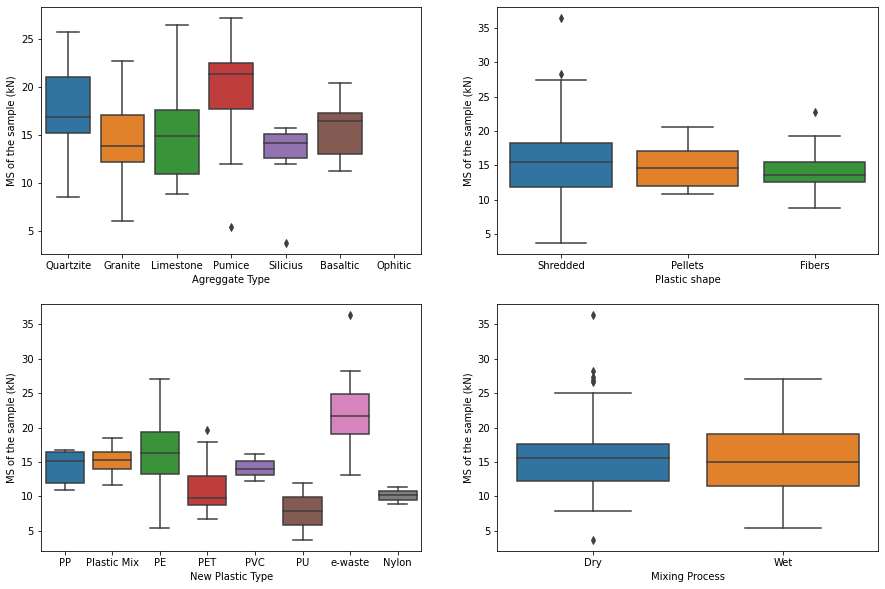

In [136]:
displayBoxPlotGraphs(dataFrame = dfMSModified, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

-------------------------------
#  3. Marshall Flow

In [37]:
dfMF = eliminateOutliers(dfMF, 'MF of the sample [mm]')
dfMF.info()

Initial dataframe size: (296, 35)
Final dataframe size: (281, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 1 to 316
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Aricle ID                               281 non-null    object 
 1   Global ID                               281 non-null    object 
 2   Modified asphaly Mix?                   281 non-null    object 
 3   Agreggate Type                          146 non-null    object 
 4   Aggregate absorption [%]                173 non-null    float64
 5   Apparent specific gravity               87 non-null     float64
 6   0.075                                   213 non-null    float64
 7   0.3                                     251 non-null    float64
 8   0.6                                     221 non-null    float64
 9   2.36                                    232 non-null    float64
 

## 3.1 Data Exploration
###  3.1.1 Total Sample

In [ ]:
dfMF.describe(include = "all")


-------------------------------
#  4. ITS

In [ ]:
dfITS = eliminateOutliers(dfITS, 'ITS of the sample [Mpa]')

## 4.1 Data Exploration
###  4.1.1 Total Sample

In [ ]:
dfITS.describe(include = "all")


-------------------------------
#  5. TSR

In [ ]:
dfTSR = eliminateOutliers(dfTSR, 'TSR of the sample[%]')

## 5.1 Data Exploration
###  5.1.1 Total Sample

In [ ]:
dfTSR.describe(include = "all")